In [2]:
pip install -U skimpy fasttext gensim wordcloud levenshtein

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\python.exe -m pip install --upgrade pip' command.


In [53]:
from skimpy import skim
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import nltk
import re
import json
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import fasttext 
import plotly.express as px
from transformers import AutoTokenizer
from Levenshtein import ratio as levenshtein_distance 
from gensim import downloader
import seaborn as sns
from gensim.parsing.preprocessing import preprocess_string, strip_numeric, strip_punctuation, strip_short, strip_multiple_whitespaces
from typing import Optional, List, Any, Tuple, Dict, Generator
import wordcloud
from nltk.tokenize import word_tokenize
tqdm.pandas()

In [54]:
df = pd.read_csv('train.csv')

In [55]:
df.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


In [56]:
df = df.rename(columns={'score': 'labels', 'full_text': 'text'})
df = df.drop(columns=['essay_id'], axis=1)

In [57]:
df.head()

,text,labels
0,Many people have car where they live. The thin...,3
1,I am a scientist at NASA that is discussing th...,3
2,People always wish they had the same technolog...,4
3,"We all heard about Venus, the planet without a...",4
4,"Dear, State Senator\n\nThis is a letter to arg...",3


EDA - Analayse du dataset

In [58]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 17307  │ │ string      │ 1     │                                                          │
│ │ Number of columns │ 2      │ │ int64       │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column_name        ┃ NA   ┃ NA %    ┃ mean    ┃ sd   ┃ p0   ┃ p25    ┃ p50    ┃ p75   ┃ p100    ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━┩  │
│ │ labels             │    0 │       0 │     2.9 │    1 │    1 │      2 │      3 │     4 │       6 │  ▂▆▇▅▁   │  │
│ └────────────────────┴──────┴─────────┴─────────┴──────┴──────┴────────┴────────┴───────┴─────────┴──────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ text                      │       0 │          0 │                          380 │                  6643794 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

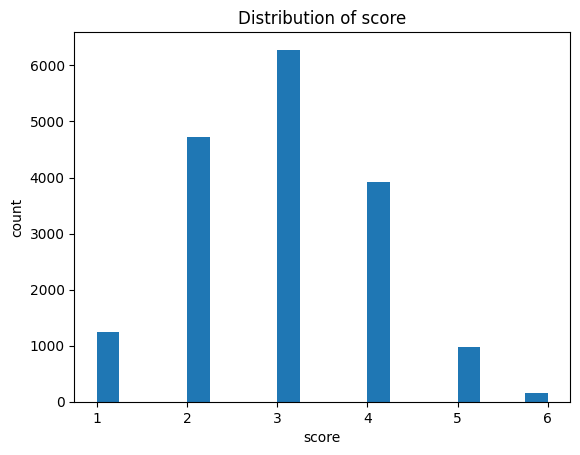

In [59]:
plt.hist(df['labels'], bins=20)
plt.xlabel('score')
plt.ylabel('count')
plt.title('Distribution of score')
plt.show()

La colonne à prédire est la colonne `score`, on remarque que les valeures prenables sont discrètes, on pourrait donc avoir envie de se diriger vers une classification. Cependant, le caractère ordinal de notre *label* ainsi que la distribution qui semble normale nous donne envie de nous diriger vers une régression. Cependant, on de part le fait que la variable est discrète, on sera contraint à arrondir à l'entier le plus proche, après tot c'est ce que font les correcteurs du BAC français donc pourquoi pas la machine ?

In [60]:
nltk.download('punkt')

def compute_length(text: str) -> int:
    """
    Compute the length of the text

    Args:
        text {str} the text to be processed
    Returns:
        int: the length of the text
    """
    
    return len(word_tokenize(text))

[nltk_data] Downloading package punkt to /home/v8/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [61]:
df['length'] = df['text'].progress_apply(compute_length)

  0%|          | 0/17307 [00:00<?, ?it/s]

In [62]:
def plot_violins(df: pd.DataFrame, 
                 x: str, 
                 y: str,
                 output_path: Optional[str] = None) -> None:
    """
    Plot violin plots

    Args:
        df {pd.DataFrame} -- the dataframe
        x {str} -- the x-axis
        y {str} -- the y-axis
        output_path {Optional[str]} -- the output path
    """
    
    plt.figure(figsize=(10, 6))
    sns.violinplot(x=x, y=y, data=df)
    plt.title(f'{y} vs {x}')
    if output_path:
        plt.savefig(output_path)
    plt.show()

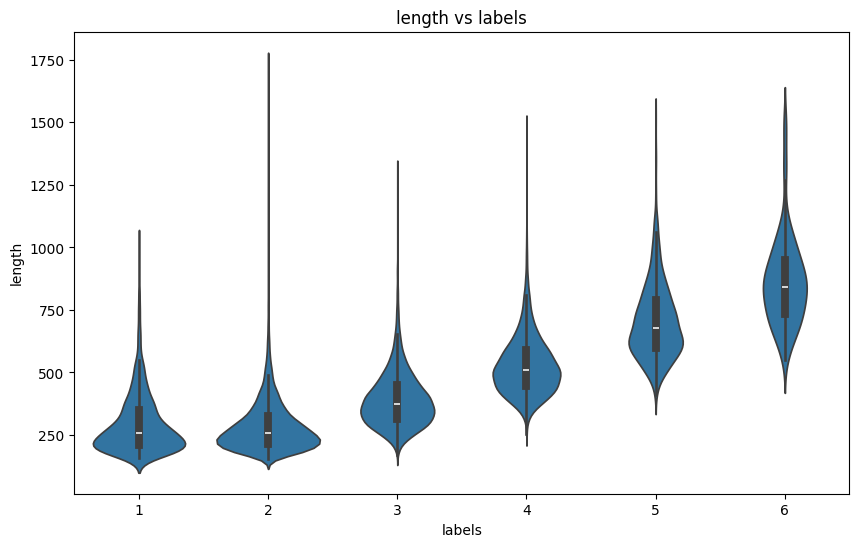

In [63]:
plot_violins(df, 'labels', 'length')

La figure ci-dessus nous montre l'évolution du nombre de tokens en fonction de la note, on remarque que c'est complètement croissant. Une nouvelle qui peut rendre la tâche plus compliquée c'est la taille que certains essais peuvent atteindre, en effet on remarque certains peuvent dépasser les 1000 tokens, pour information, un modèle comme `BERT` ne prend en entrée que 512 tokens (même si, forcément, ce sera pas le même tokenizer, on peut tout de même connjecturer qu'on dépassera le seuil facilement). Si on utilise ce genre de modèle, il faudra donc se résoudre à réfléchir à comment intégrer un maximum d'informations.

In [64]:
def plot_word_clouds(df: pd.DataFrame, 
                     column: str,
                     output_path: Optional[str] = None) -> None:
    """
    Plot word clouds for each label

    Args:
        df {pd.DataFrame} -- the dataframe
        column {str} -- the column to be processed
        output_path {Optional[str]} -- the output path
    """

    fig, axes = plt.subplots(2, 3, figsize=(20, 8))
    labels = sorted(df['labels'].unique())

    for i, label in enumerate(labels):
        ax = axes[i // 3, i % 3]
        wc = wordcloud.WordCloud(width=800, height=400).generate(' '.join(df[df['labels'] == label][column]))
        ax.imshow(wc)
        ax.set_title(f'{label}')
        ax.axis('off')
    
    plt.suptitle(f'Word Clouds of each score', fontsize=20, y=0.96)
    plt.tight_layout
    if output_path:
        plt.savefig(output_path)
    plt.show()

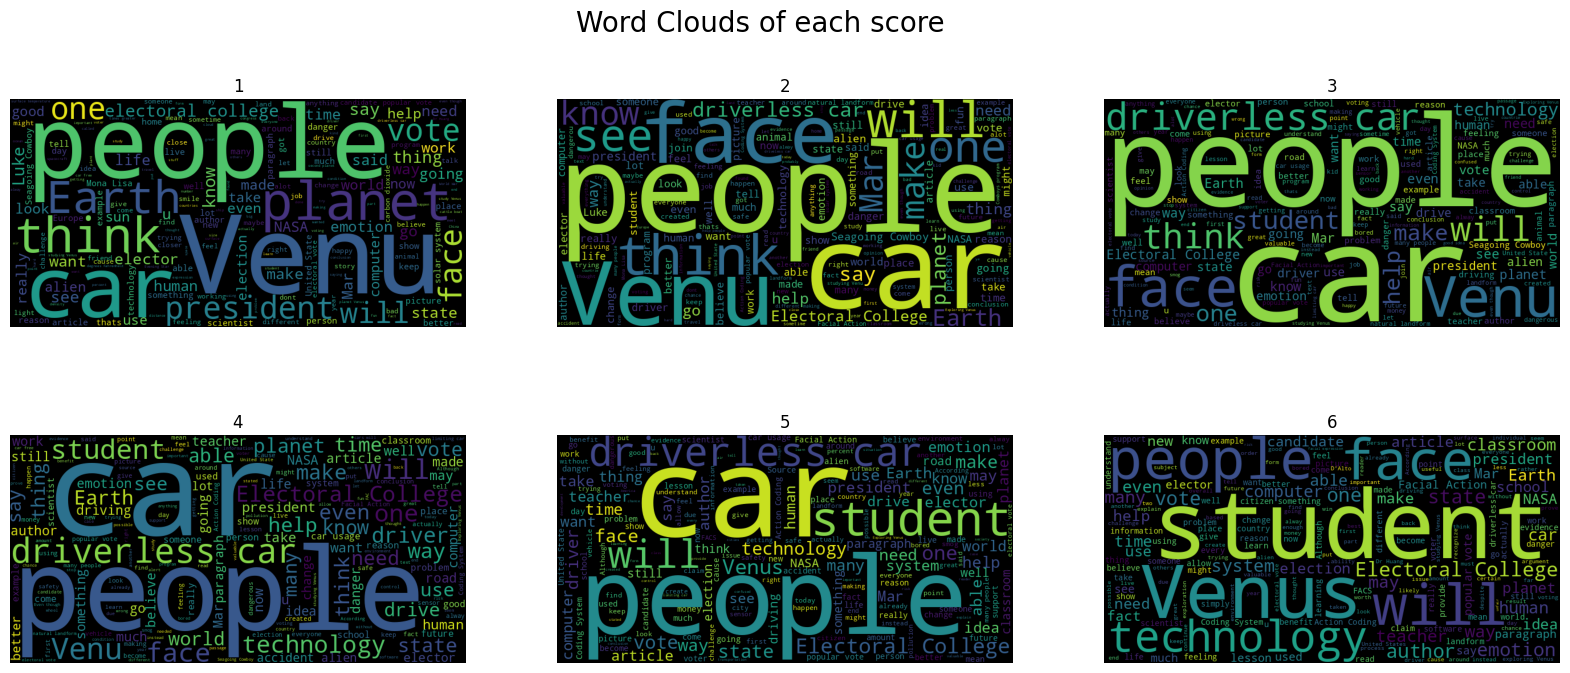

In [65]:
plot_word_clouds(df, 'text')

La figure ci dessus nous montre les mots les plus fréquents en fonction de la note, une première remarque, c'est qu'on aurait pu combiner cette visualisation avec du preprocessing comme le stemming, lemmatisation ou ben juste la supression de stopwords(c'est ce que je fais habituellement pour être honnête). Mais si on se place dans le contexte d'essais qui visent à être noté, un première chose qu'on peut souligner c'est que les fautes seront moins fréquentes que dans des tweets, donc le côté "factorisant" des techniques mentionnées ne seraient pas tant que ça une plus value, maintenant si on s'intéressait aux lemmes (ou bien juste à un degré de précision plus bas), ça pourrait tout de même être intéressant de voir le résultat.  

Ce qu'on peut notifier sur notre figure, c'est que globalement on retrouve les mêmes termes, montrant que les essais font sûrement parti d'une discipline particulière, de plus on remarque le mot *student* émerger en même temps que la note croit.  

On va peut être se concentrer sur le top 3 pour chaque note pour voir si on peut distinguer certaines choses plus précises(Wordcloud fais lui même un travail sur les stopwords, la on va devoir le faire nous même)

Avant d'implementer la fonction, je propose de faire un nettoyage sur notre colonne `text`, plusieurs options s'offre à nous. Soit on implémente nous même une fonction utilisant les modules `re` ainsi que `nltk`, l'avantage serait qu'on aurait un controle complet du nettoyage. Ou bien, plus rapide, on utilise une fonction de `gensim` `preprocessing_string` qui nettoie très efficacement le texte. Attention ! Cette fonction applique du stemming

In [66]:
df["stemmed_text"] = df["text"].progress_apply(lambda x: " ".join(preprocess_string(x)))

  0%|          | 0/17307 [00:00<?, ?it/s]

In [67]:
def plot_podium(df: pd.DataFrame, 
                column: str,
                top_k: int = 3,
                output_path: Optional[str] = None) -> None:
    """
    Plot podiums for each label

    Args:
        df {pd.DataFrame} -- the dataframe
        column {str} -- the column to be processed
        output_path {Optional[str]} -- the output path
    """

    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    labels = sorted(df['labels'].unique())

    for i, label in enumerate(labels):
        ax = axes[i // 3, i % 3]
        top_words = pd.Series(' '.join(df[df['labels'] == label][column]).split()).value_counts().head(top_k)
        top_words = top_words.sort_values(ascending=True)
        top_words.plot(kind='barh', ax=ax)
        ax.set_title(f'{label}')
    
    plt.suptitle(f'Top {top_k} words of each score', fontsize=20)
    plt.tight_layout
    if output_path:
        plt.savefig(output_path)
    plt.show()

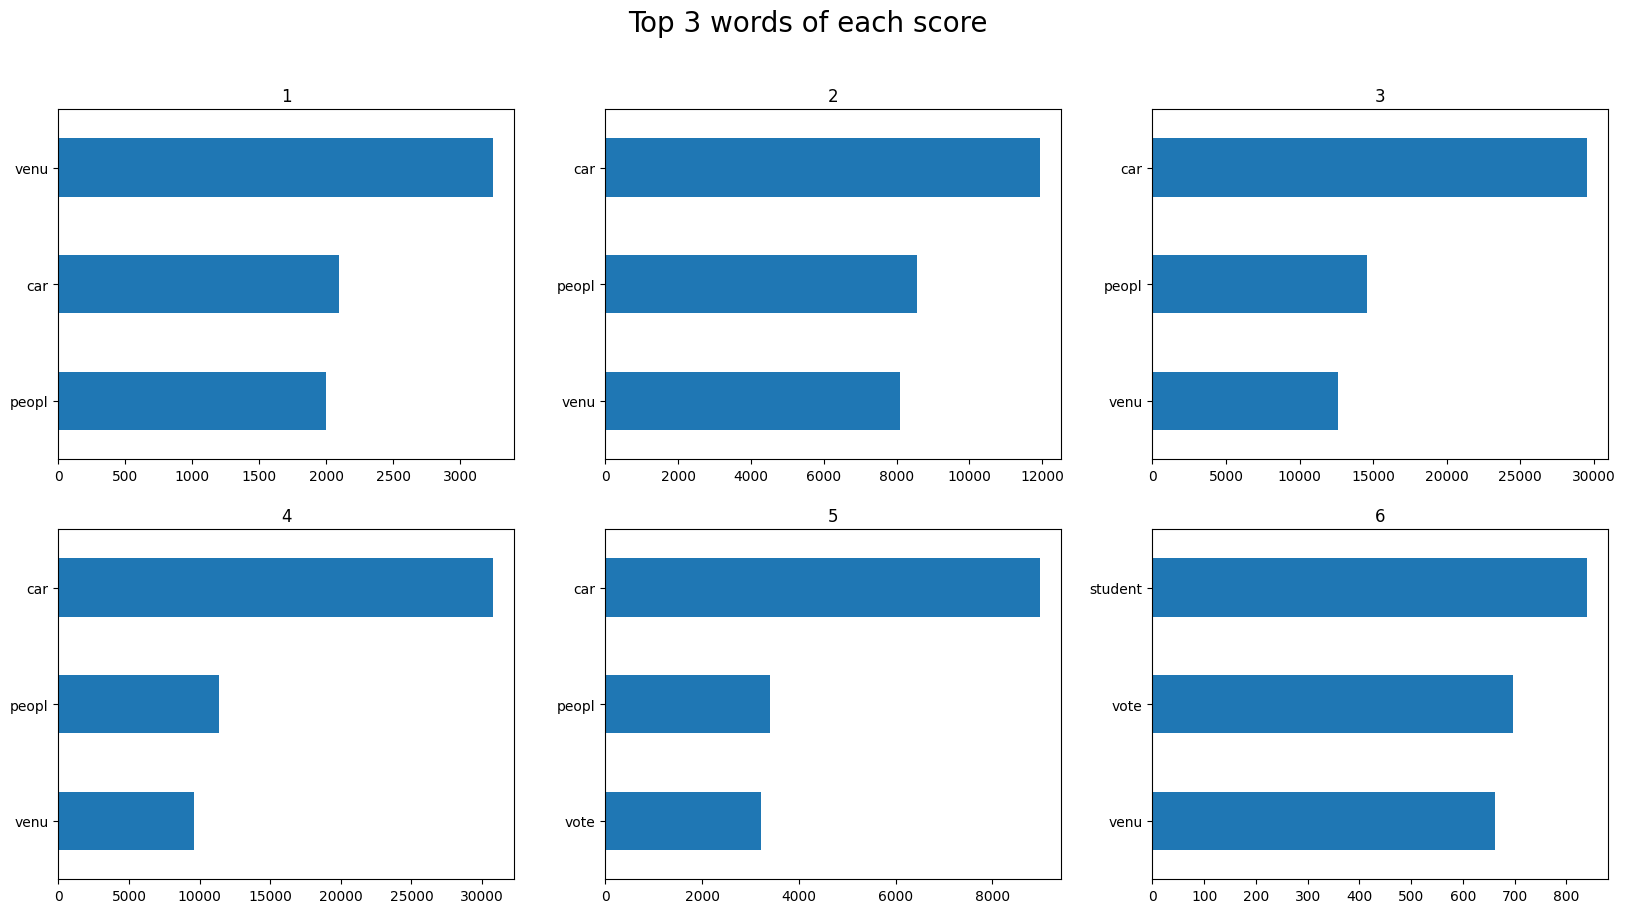

In [68]:
plot_podium(df, 'stemmed_text')

On peut reprendre les mêmes constats faits pour la figure précedente. On a globalement les mêmes tokens qui apparaissent pour chaque note.

Dans ce projet, nous allons entrainer de smodèles de différentes manières. Il y aura de la régression puis arrondissement, mais aussi différentes méthodologies d'entraînements. Notamment ce qu'on peut appeler la **FeatureExtraction**. Ce qu'on va faire c'est que nous allons utiliser une technique de vectorisation fréquentielle (`TF-IDF`), qu'on va comparer à d'autres méthodes d'embeddings, notamment `GloVe`, `FastText`et une architecture de style Transformer (Auto-Encoder, ou ce qu'on appelle EmbeddingModel).  

Avant d'entrainer des modèles de Machine Learning, on peut visualiser nos données vectorisée à l'aide d'algorithme de réduction de dimension.

In [69]:
info_model = downloader.info()

for model_name, model_info in info_model['models'].items():
    if 'glove' in model_name:
        print(model_name, model_info['file_size'])

glove-wiki-gigaword-50 69182535
glove-wiki-gigaword-100 134300434
glove-wiki-gigaword-200 264336934
glove-wiki-gigaword-300 394362229
glove-twitter-25 109885004
glove-twitter-50 209216938
glove-twitter-100 405932991
glove-twitter-200 795373100


On a ci-dessus la liste de tous les modèles qu'on peut directement télécharger avec la fonction `load`

In [70]:
glove = downloader.load('glove-wiki-gigaword-300')

Il ne faut jamais combiner des techniques tel que le stemming avec des modèles pré-entrainés, au risque de ne se retrouver qu'avec des tokens inconnus. Les modèles ont un vocabulaire bien fixé. (Note: l'affirmation sur les tokens inconnus n'est pas tout à fait vraie pour les modèles transformers)

Maintenant nous allons analyser à quel point le modèle couvre le vocabulaire de notre corpus, c'est une information essentielle pour la suite.

In [71]:
def simple_cleaning(text: str) -> str:
    """
    Simple cleaning

    Args:
        text {str} -- the text to be processed
    Returns:
        str: the processed text
    """

    text = strip_multiple_whitespaces(text)
    text = strip_numeric(text)
    text = strip_punctuation(text)
    text = strip_short(text)

    text = text.lower()
    
    return text                                 

In [72]:
df["simple_cleaned_text"] = df["text"].progress_apply(simple_cleaning)

  0%|          | 0/17307 [00:00<?, ?it/s]

In [73]:
df

,text,labels,length,stemmed_text,simple_cleaned_text
0,Many people have car where they live. The thin...,3,545,peopl car live thing know us car alot thing ha...,many people have car where they live the thing...
1,I am a scientist at NASA that is discussing th...,3,371,scientist nasa discuss face mar explain face l...,scientist nasa that discussing the face mars w...
2,People always wish they had the same technolog...,4,605,peopl wish technolog seen movi best new piec t...,people always wish they had the same technolog...
3,"We all heard about Venus, the planet without a...",4,511,heard venu planet oxygen earthquak erupt volca...,all heard about venus the planet without almos...
4,"Dear, State Senator\n\nThis is a letter to arg...",3,418,dear state senat letter argu favor keep electo...,dear state senator this letter argue favor kee...
...,...,...,...,...,...
17302,"the story "" The Challenge of Exploing Venus "" ...",2,167,stori challeng explo venu inform piec danger r...,the story the challenge exploing venus informa...
17303,Technology has changed a lot of ways that we l...,4,644,technolog chang lot wai live todai nowadai pho...,technology has changed lot ways that live toda...
17304,If you don't like sitting around all day than ...,2,235,like sit dai great opportun particip seago cow...,you don like sitting around all day than great...
17305,"In ""The Challenge of Exporing Venus,"" the auth...",1,264,challeng expor venu author suggest studi venu ...,the challenge exporing venus the author sugges...


In [74]:
words = word_tokenize(' '.join(df['simple_cleaned_text']))

In [75]:
print(f"There is a total of {len(words)} words, from which {len(set(words))} are unique")

There is a total of 5024506 words, from which 63979 are unique


In [76]:
def vocabulary_coverage_glove(df: pd.DataFrame,
                              column: str,
                              model) -> dict:
    """
    Compute the vocabulary coverage

    Args:
        df {pd.DataFrame} -- the dataframe
        column {str} -- the column to be processed
        model {model} -- the gloVe model
    Returns:
        float: the vocabulary coverage
    """

    words = set(model.index_to_key)
    text = ' '.join(df[column])
    words_in_text = set(word_tokenize(text))

    dict_out = {
        'vocabulary_coverage': len(words_in_text.intersection(words)) / len(words_in_text),
        'words_not_in_glove': words_in_text.difference(words)
    }

    return dict_out

In [77]:
value_coverage = vocabulary_coverage_glove(df, 'simple_cleaned_text', glove)

In [78]:
value_coverage2 = vocabulary_coverage_glove(df, 'stemmed_text', glove)

In [79]:
def plot_value_coverage(list_dict: list,
                        list_labels: list,
                        output_path: Optional[str] = None) -> None:
    
    """
    Plot the value coverage

    Args:
        list_dict {list} -- the list of dictionaries
        list_labels {list} -- the list of labels
        output_path {Optional[str]} -- the output path
    """

    val = [x['vocabulary_coverage'] for x in list_dict]

    plt.bar(list_labels, val)
    plt.title('Vocabulary Coverage')
    if output_path:
        plt.savefig(output_path)
    plt.show()


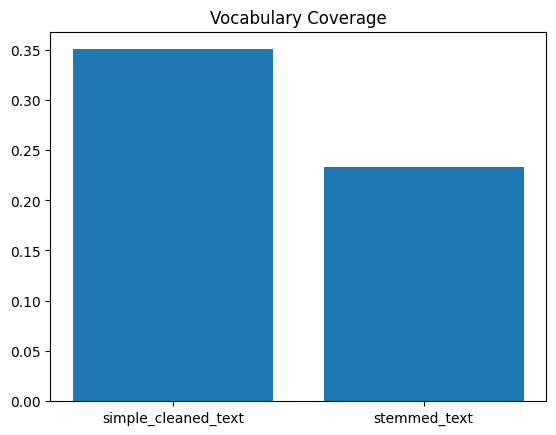

In [80]:
plot_value_coverage([value_coverage, value_coverage2], ['simple_cleaned_text', 'stemmed_text'])

Une première limite qu'on rencontre avec les Word embeddings comme wave2vec ou gloVe c'est cette dépédence au vocab qui n'est constitué que de mot, comme on peut voir sur notre ensemble de données seulement 35 % des tokens sont reconnus, ce nombre peut peut-être suffire pour notre use-case mais nous allons tout de même essayer d'augmenter ça. Malheureusement, on ne peut pas le faire sur tout le dataset mais que sur l'ensemble d'entrainement, sinon on se confronte au data leakage. Une solution pour remédier à ca c'est soit d'utiliser FastText qui justemet lui se base sur les n-grams et par conséquent rien ne lui est inconnu, soit d'augmenter ce % avec des métriques comme la distance de Levenhstein ou autre.

In [81]:
glove_twitter = downloader.load('glove-twitter-200')

In [82]:
value_coverage_twitter = vocabulary_coverage_glove(df, 'simple_cleaned_text', glove_twitter)

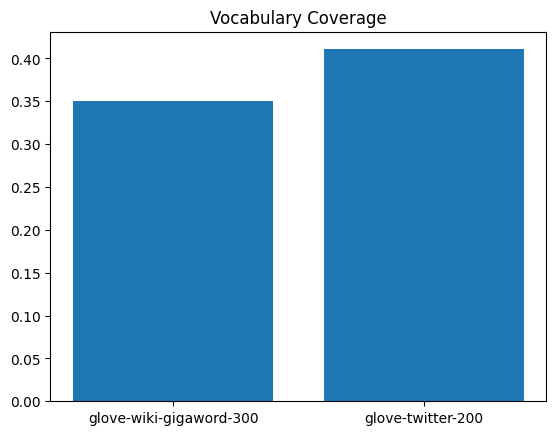

In [83]:
plot_value_coverage([value_coverage, value_coverage_twitter], ['glove-wiki-gigaword-300', 'glove-twitter-200'])

On remarque que le `glove-twitter-200` a un meilleur vocabulary coverage que le modèle choisi initialement. Nous allons observé les mots non-reconnus.

In [84]:
not_recognized_sample = list(value_coverage_twitter['words_not_in_glove'])
print(f"Some of the words not recognized by the model are: \n{not_recognized_sample[:10]}")

Some of the words not recognized by the model are: 
['lamborginis', 'enagage', 'rightchesness', 'leftr', 'outcomings', 'miscommunicatiom', 'eclaimed', 'emottional', 'movents', 'sitiuions']


In [85]:
def plot_not_recognized(not_recognized_sample: List[str],
                        output_path: Optional[str] = None) -> None:
    """
    Plot the not recognized words

    Args:
        not_recognized_sample {List[str]} -- the list of not recognized words
        output_path {Optional[str]} -- the output path
    """

    not_recognized_sample = [x for x in not_recognized_sample if x.isalpha()]
    not_recognized_sample = [x for x in not_recognized_sample if len(x) > 1]

    not_recognized_sample = pd.Series(not_recognized_sample).str[0].value_counts().sort_index()

    plt.bar(not_recognized_sample.index, not_recognized_sample)
    plt.title('Not recognized words')
    if output_path:
        plt.savefig(output_path)
    plt.show()

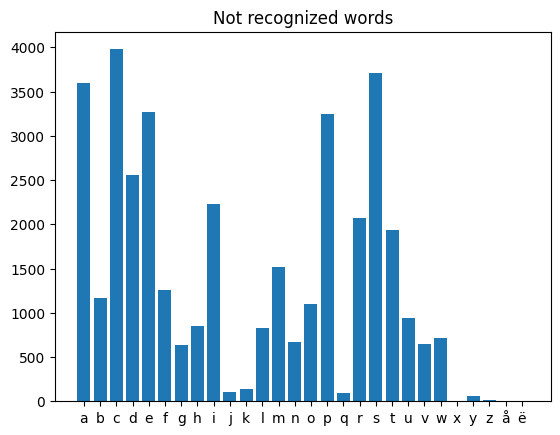

In [86]:
plot_not_recognized(not_recognized_sample)

On remarque encore une fois des erreurs, nous allons tenter de corriger ça et optimiser ce % avec la distance de levhenstein

In [87]:
def glove_levensthein_stream(df: pd.DataFrame,
                             column: str,
                             model) -> Generator[Tuple[str, str, float], None, None]:
    """
    Stream glove levenshtein distances

    Args:
        df {pd.DataFrame} -- the dataframe
        column {str} -- the column to be processed
        model {model} -- the model
    Yields:
        Generator[Tuple[str, str, float], None, None]: word, closest word, and distance (ratio)
    """

    vocabulary_cov = vocabulary_coverage_glove(df, column, model)
    words_not_in_glove = vocabulary_cov['words_not_in_glove']
    words_data = set(model.index_to_key)
    words_data = {re.sub(r'[^\w\s]', '', word) for word in words_data}
    words_data.discard('')

    for word in tqdm(words_not_in_glove, desc='Computing distances', total=len(words_not_in_glove)):
        best_match, max_ratio = None, 0.0
        for word_data in words_data:
            ratio = levenshtein_distance(word, word_data)
            if ratio > max_ratio:
                max_ratio, best_match = ratio, word_data
        yield word, best_match, max_ratio

def create_corrected_dict(stream: Generator[Tuple[str, str, float], None, None], 
                          threshold: float = 0.7) -> Dict[str, str]:
    """
    Create the corrected dictionary from the stream

    Args:
        stream {Generator[Tuple[str, str, float], None, None]} -- the stream of word pairs and distances (ratios)
        threshold {float} -- the threshold
    Returns:
        Dict[str, str]: the corrected dictionary with the previous word as key and the corrected word as value
    """

    corrected_dict = {}
    for word, best_match, ratio in stream:
        if ratio > threshold:
            corrected_dict[word] = best_match

    return corrected_dict

In [49]:
glove_stream = glove_levensthein_stream(df, 'simple_cleaned_text', glove)

In [50]:
glove_corrected_dict = create_corrected_dict(glove_stream)

Computing distances:   0%|          | 0/41557 [00:00<?, ?it/s]

In [51]:
json.dump(glove_corrected_dict, open('corrected_dict.json', 'w'))

In [88]:
def correct_text(text: str, 
                 corrected_dict: Dict[str, str]) -> str:
    """
    Correct the text

    Args:
        text {str} -- the text to be corrected
        corrected_dict {Dict[str, str]} -- the corrected dictionary
    Returns:
        str: the corrected text
    """
    
    tokens = word_tokenize(text)

    for i, token in enumerate(tokens):
        if token in corrected_dict:
            tokens[i] = corrected_dict[token]
    
    corrected_text = ' '.join(tokens)

    return corrected_text

In [89]:
glove_corrected_dict = json.load(open('corrected_dict.json'))

In [90]:
df['corrected_text'] = df['simple_cleaned_text'].progress_apply(lambda x: correct_text(x, glove_corrected_dict))

  0%|          | 0/17307 [00:00<?, ?it/s]

In [91]:
print(f"Original text: {df['simple_cleaned_text'][0]}\nCorrected text: {df['corrected_text'][0]}")

Original text: many people have car where they live the thing they don know that when you use car alot thing can happen like you can get accidet the smoke that the car has bad breath someone walk but vauban germany they dont have that proble because percent vauban families not own cars and percent sold car move there street parkig driveways and home garages are forbidden the outskirts freiburd that near the french and swiss borders you probaly won see car vauban streets because they are completely car free but some that lives vauban that owns car ownership allowed but there are only two places that you can park large garages the edge the development where car owner buys space but not cheap buy one they sell the space for you car for along with home the vauban people completed this they said that this example growing trend europe the untile states and some where else are suburban life from auto use this called smart planning the current efforts drastically reduce greenhouse gas emission

In [92]:
df.head()

,text,labels,length,stemmed_text,simple_cleaned_text,corrected_text
0,Many people have car where they live. The thin...,3,545,peopl car live thing know us car alot thing ha...,many people have car where they live the thing...,many people have car where they live the thing...
1,I am a scientist at NASA that is discussing th...,3,371,scientist nasa discuss face mar explain face l...,scientist nasa that discussing the face mars w...,scientist nasa that discussing the face mars w...
2,People always wish they had the same technolog...,4,605,peopl wish technolog seen movi best new piec t...,people always wish they had the same technolog...,people always wish they had the same technolog...
3,"We all heard about Venus, the planet without a...",4,511,heard venu planet oxygen earthquak erupt volca...,all heard about venus the planet without almos...,all heard about venus the planet without almos...
4,"Dear, State Senator\n\nThis is a letter to arg...",3,418,dear state senat letter argu favor keep electo...,dear state senator this letter argue favor kee...,dear state senator this letter argue favor kee...


In [93]:
value_coverage_corrected = vocabulary_coverage_glove(df, 'corrected_text', glove_twitter)

In [94]:
value_coverage_wiki_corrected = vocabulary_coverage_glove(df, 'corrected_text', glove)

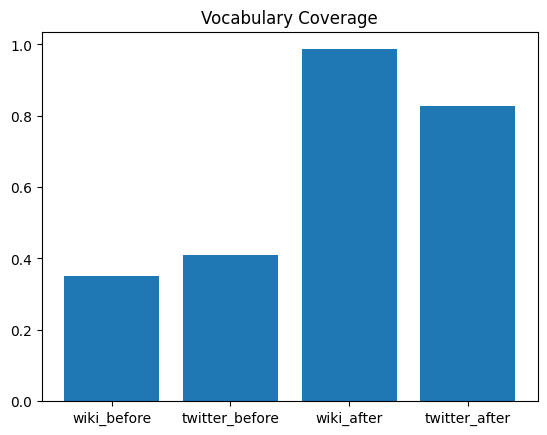

In [95]:
plot_value_coverage([value_coverage, value_coverage_twitter, value_coverage_wiki_corrected, value_coverage_corrected], 
                    ['wiki_before', 'twitter_before', 'wiki_after', 'twitter_after'])

In [96]:
print(f"Some examples of remaining words not recognized by the model:\n{list(value_coverage_wiki_corrected['words_not_in_glove'])[:10]}")

Some examples of remaining words not recognized by the model:
['eclass', 'darte', 'twoact', 'tbird', 'technologydriven', 'typeb', 'dday', 'thirtyfour', 'thirdperson', 'evergrowing']


In [65]:
df.to_csv('train_cleaned.csv', index=False)

Après l'utilisation de la distance de levenshtein avec un ratio assez strict, on obtien presque 100% de vocabulary coverage. On remarque que ca a même augmenté cconsidérablement elui du modèle entrainé sur twitter.

J'ai mentionné plus haut que on se préocupait pas vraiment d'avoir des tokens inconnus dans le cadre d'architecture transformer. En effet, la plupart des vocabulaires associés à ces modèles construit avec des algorithmes comme Word piece ou Sentence Piece possède les caractères atomiques dans leur vocabulaire. Si on prend l'algorithme BPE, on par des caractères ASCII codés sur un octet chacun, puis en faisant itérativement des statistiques de co-occurences entre ces caractères, puis des combinaisons de de caractères et ainsi de suite, on se retrouve avec les caractères de base et le combinaisons (puis mots) les plus fréquents. On retrouve tout de même une notion de qualité de vocabulaire et ce que nous allons tenter d'explorer.

Pour ce faire nous allons nous intéresser à deuc tokenizer de deux modèles différents, un qui semble pertinent et un autre qui semble moins pertinent. 

In [97]:
model_code = "codeparrot/codeparrot"
model_nlp = "BAAI/bge-large-en-v1.5"

On a donc un modèle qui a été entrainé sur du code python, et donc un tokenizer qui également été entrainé sur du code, et d'un autre coté un modèle de type SBERT, qui sont particulièrement efficace pour la compréhension de texte et pour les tâches dites NLI

In [98]:
tokenizer_parrot = AutoTokenizer.from_pretrained(model_code)

In [99]:
tokenizer_nlp = AutoTokenizer.from_pretrained(model_nlp)

Si on part du principie qu'il y a cet entrainement itératif comme mentionné plus haut, cela signifique que les mots incconus seront découpés en un certain nombre de n-grams, et donc il est légitime de penser que si on fait une courbe du nombre de tokens en fonction du nombre de caracètres et qu'on asocie à ca une régression linéaire, un tokenizer entrainé sur un corpus plus représentatif des mots que nous avons dans notre dataset se courbe en dessous d'un modèle moins pertinent, observons ça

In [100]:
# tokenizer overview
print(tokenizer_parrot)

GPT2TokenizerFast(name_or_path='codeparrot/codeparrot', vocab_size=32768, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


In [101]:
print(tokenizer_nlp)

BertTokenizerFast(name_or_path='BAAI/bge-large-en-v1.5', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


On remarque pleins de paramètres, comme la taille du vaocabulaire ainsi que des stratégies de processing (padding/truncation)
Tokenizons une phrase en particulier

In [102]:
prompt_test = "def hello_world():\n    print('Hello, World!')\n\nhello_world()"

out_parrot = tokenizer_parrot(prompt_test, return_tensors="pt", add_special_tokens=False)
out_bge = tokenizer_nlp(prompt_test, return_tensors="pt", add_special_tokens=False)

In [103]:
out_parrot

{'input_ids': tensor([[  318, 16509,    63,  7617,   837,   272,   870,   360,  6257,    12,
         13064, 10916,   199,   199,  5006,    63,  7617,   342]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [104]:
out_bge

{'input_ids': tensor([[13366,  7592,  1035,  2088,  1006,  1007,  1024,  6140,  1006,  1005,
          7592,  1010,  2088,   999,  1005,  1007,  7592,  1035,  2088,  1006,
          1007]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

On retrouve ici les identifiants des tokens, le token-type_ids qui est nécessaire pour les taches de NSP et l'attention maskpermettant de faire la différence entre le pading et les tokens du texte source.

In [105]:
print(f'Length of the input for the model_code: {len(out_parrot["input_ids"][0])}\nLength of the input for the model_nlp: {len(out_bge["input_ids"][0])}')

Length of the input for the model_code: 18
Length of the input for the model_nlp: 21


On remarque qu'il y a 3 tokens de plus pour bge lorsqu'il faut tokenizer une fonction python

In [106]:
print(tokenizer_parrot.convert_ids_to_tokens(out_parrot['input_ids'][0]))

['def', 'Ġhello', '_', 'world', '():', 'ĊĠĠĠ', 'Ġprint', "('", 'Hello', ',', 'ĠWorld', "!')", 'Ċ', 'Ċ', 'hello', '_', 'world', '()']


In [107]:
print(tokenizer_nlp.convert_ids_to_tokens(out_bge['input_ids'][0]))

['def', 'hello', '_', 'world', '(', ')', ':', 'print', '(', "'", 'hello', ',', 'world', '!', "'", ')', 'hello', '_', 'world', '(', ')']


On remarque que sur les ponctuations, les deux tokenizer ne procèdent pas de la même manière. En effet, code-parrot a vu plus de code python que bge et a jugé que `():` apparaissait fréquement et les a donc regroupé  
Note: Les espace tabluations et autres on été remplacé par des caractères spéciauw non-utilisés, code-parrot a repris les mêmes patterns que gpt2

In [108]:
df_count = pd.DataFrame(columns=['parrot_length', 'n_chars', 'bge_length'])

df_count['parrot_length'] = df['corrected_text'].progress_apply(lambda x: len(tokenizer_parrot(x, add_special_tokens=False)['input_ids']))
df_count['n_chars'] = df['corrected_text'].progress_apply(lambda x: len(x))
df_count['bge_length'] = df['corrected_text'].progress_apply(lambda x: len(tokenizer_nlp(x, add_special_tokens=False)['input_ids']))

  0%|          | 0/17307 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1194 > 1024). Running this sequence through the model will result in indexing errors


  0%|          | 0/17307 [00:00<?, ?it/s]

  0%|          | 0/17307 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


In [109]:
df.head()

,text,labels,length,stemmed_text,simple_cleaned_text,corrected_text
0,Many people have car where they live. The thin...,3,545,peopl car live thing know us car alot thing ha...,many people have car where they live the thing...,many people have car where they live the thing...
1,I am a scientist at NASA that is discussing th...,3,371,scientist nasa discuss face mar explain face l...,scientist nasa that discussing the face mars w...,scientist nasa that discussing the face mars w...
2,People always wish they had the same technolog...,4,605,peopl wish technolog seen movi best new piec t...,people always wish they had the same technolog...,people always wish they had the same technolog...
3,"We all heard about Venus, the planet without a...",4,511,heard venu planet oxygen earthquak erupt volca...,all heard about venus the planet without almos...,all heard about venus the planet without almos...
4,"Dear, State Senator\n\nThis is a letter to arg...",3,418,dear state senat letter argu favor keep electo...,dear state senator this letter argue favor kee...,dear state senator this letter argue favor kee...


In [110]:
fig = px.scatter(df_count, x='n_chars', y='parrot_length', trendline='ols', title='Parrot')
fig.show()

fig = px.scatter(df_count, x='n_chars', y='bge_length', trendline='ols', title='BGE')
fig.show()


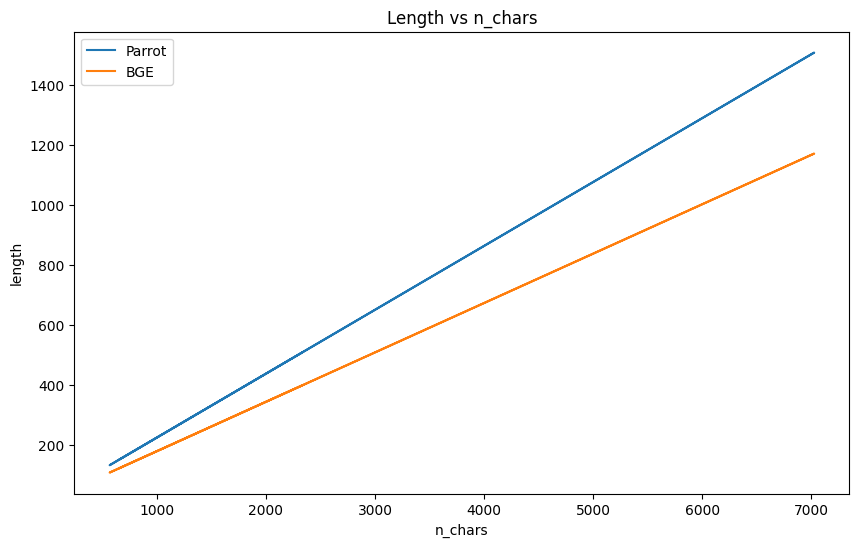

In [111]:
parrot_coef = 0.21324
bge_coef = 0.164849
parrot_b = 10.5084
bge_b = 13.3983

plt.figure(figsize=(10, 6))
plt.plot(df_count['n_chars'], parrot_coef * df_count['n_chars'] + parrot_b, label='Parrot')
plt.plot(df_count['n_chars'], bge_coef * df_count['n_chars'] + bge_b, label='BGE')

plt.xlabel('n_chars')
plt.ylabel('length')
plt.title('Length vs n_chars')
plt.legend()
plt.show()

Et en effet, on remarque qu'ici `bge` reconnait d'avantages de tokens que `code-parrot`, montrant que son vocabulaire recouvre d'avantage celui de notre dataset. Ceci nous communiquant une première métrique de choix de modèle pour notre tâche.